In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, DataModel, DataModelQlty, AIQlty, utils, Event, Simulation, root_files
np.set_printoptions(precision=2, linewidth=115, suppress=True)

%matplotlib inline

In [2]:
# model name
model_name = 'model-2b-lsr-quality'

# source model name to load the network weights
source_model = 'model-2b-lsr'

shuffle_clusters = False

# load the training data
data = DataModelQlty('data-qlty-enough-top-8.npz', 
                 batch_size = 256, validation_percent = .05, test_percent = .1)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AIQlty(data, model_name)

# randomly shuffle the training data
np.random.seed(888)
ai.data.shuffle(only_train=False)

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()
    
# define the priority of selection
ai.data.weight_non_compton = .1

In [3]:
# define the learning rate scheduler
def lr_scheduler(epoch):
    if epoch < 10:
        return .0003
    elif epoch < 20:
        return .00001
    else:
        return .000003

# define and create the neural network architecture
ai.init_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0001, limbs_l2=.0001)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [4]:
#LOADING THE MODEL
ai.load(source_model, optimizer=False)
ai.extend_model(quality_layers=[64, 32, 32], plot_summary=False)
ai.load(model_name, optimizer=False)
ai.compile_model()

In [5]:
ai.evaluate(quality_filter=[.65,.65,.65,.65])

AI model
  Loss:        3.65665
    -Type:         0.27808 *  2.00 = 0.55617
    -Pos X:        0.04087 *  2.50 = 0.10218
    -Pos Y:        1.11453 *  1.00 = 1.11453
    -Pos Z:        0.04519 *  2.00 = 0.09038
    -Energy:       1.03453 *  1.50 = 1.55179
    -Cls e:        0.03388 *  1.00 = 0.03388
    -Cls p:        0.07837 *  1.00 = 0.07837
    -Quality:      0.03172 *  1.00 = 0.03172
  Accuracy:    0.88177
    -TP rate:      0.83661
    -Cls e rate:   0.95352
    -Cls p rate:   0.89541
  Efficiency:  0.10180
  Purity:      0.25725
  Euc mean:    5.97338
  Euc std:    11.05558

Reco
  Accuracy:    0.64592
    -TP rate:      0.74924
  Efficiency:  0.10264
  Purity:      0.05959
  Euc mean:   20.44427
  Euc std:    48.46802


In [6]:
ai.evaluate(quality_filter=[.71,.71,.71,.71])

AI model
  Loss:        3.65665
    -Type:         0.27808 *  2.00 = 0.55617
    -Pos X:        0.04087 *  2.50 = 0.10218
    -Pos Y:        1.11453 *  1.00 = 1.11453
    -Pos Z:        0.04519 *  2.00 = 0.09038
    -Energy:       1.03453 *  1.50 = 1.55179
    -Cls e:        0.03388 *  1.00 = 0.03388
    -Cls p:        0.07837 *  1.00 = 0.07837
    -Quality:      0.03172 *  1.00 = 0.03172
  Accuracy:    0.88177
    -TP rate:      0.83661
    -Cls e rate:   0.95352
    -Cls p rate:   0.89541
  Efficiency:  0.07696
  Purity:      0.30714
  Euc mean:    5.33901
  Euc std:    10.42685

Reco
  Accuracy:    0.64592
    -TP rate:      0.74924
  Efficiency:  0.10264
  Purity:      0.05959
  Euc mean:   20.44427
  Euc std:    48.46802


In [7]:
ai.data.validation_percent = 0.0
ai.data.test_percent = 0.15
ai.export_predictions_root(root_name='sifi-cc-nn-qlty.root', quality_filter=[.71,.71,.71,.71])

In [6]:
# TRAINING THE MODEL
# load the weights of the source model
ai.load(source_model, optimizer=False)
ai.compile_model()

In [7]:
# freeze all network components
for layer in ai.model.layers:
    layer.trainable = False
    
# extend the model with the quality part
ai.extend_model(quality_layers=[64, 32, 32], limbs_l2=.0001)

# # eliminate the components weight not intended for training
ai.weight_type = 2      * 0
ai.weight_e_cluster = 1 * 0
ai.weight_p_cluster = 1 * 0
ai.weight_pos_x = 2.5   * 0
ai.weight_pos_y = 1     * 0
ai.weight_pos_z = 2     * 0
ai.weight_energy = 1.5  * 0
ai.weight_qlty = 1      * 1

# print the trainable layers
print('trainable layers:')
for layer in ai.model.layers:
    if layer.trainable:
        print('{:17s}{}'.format(layer.name, layer.trainable))

# compile the model for training
ai.compile_model(learning_rate=.0003)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
____________________________________________________________________________________________

In [8]:
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

# start the training of the network
ai.train(epochs=30, shuffle=True, shuffle_clusters=shuffle_clusters, 
         verbose=0, callbacks = l_callbacks)

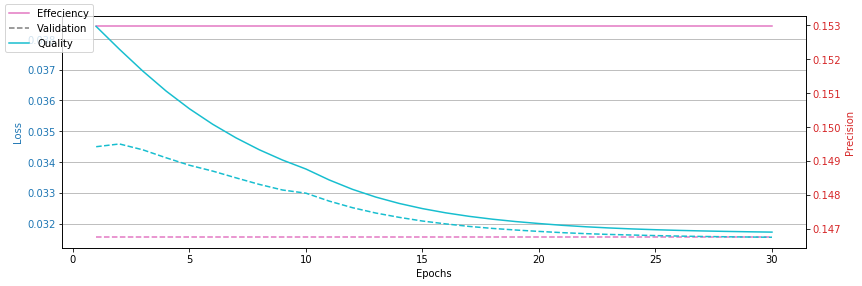

In [9]:
ai.plot_training_loss(mode='loss-quality', summed_loss=False)

In [23]:
ai.evaluate(quality_filter=[.65,.65,.65,.65])

AI model
  Loss:        3.65665
    -Type:         0.27808 *  2.00 = 0.55617
    -Pos X:        0.04087 *  2.50 = 0.10218
    -Pos Y:        1.11453 *  1.00 = 1.11453
    -Pos Z:        0.04519 *  2.00 = 0.09038
    -Energy:       1.03453 *  1.50 = 1.55179
    -Cls e:        0.03388 *  1.00 = 0.03388
    -Cls p:        0.07837 *  1.00 = 0.07837
    -Quality:      0.03172 *  1.00 = 0.03172
  Accuracy:    0.88177
    -TP rate:      0.83661
    -Cls e rate:   0.95352
    -Cls p rate:   0.89541
  Efficiency:  0.10180
  Purity:      0.25725
  Euc mean:    5.97338
  Euc std:    11.05558

Reco
  Accuracy:    0.64592
    -TP rate:      0.74924
  Efficiency:  0.10264
  Purity:      0.05959
  Euc mean:   20.44427
  Euc std:    48.46802


In [11]:
# save the trained model
ai.save(file_name=model_name)

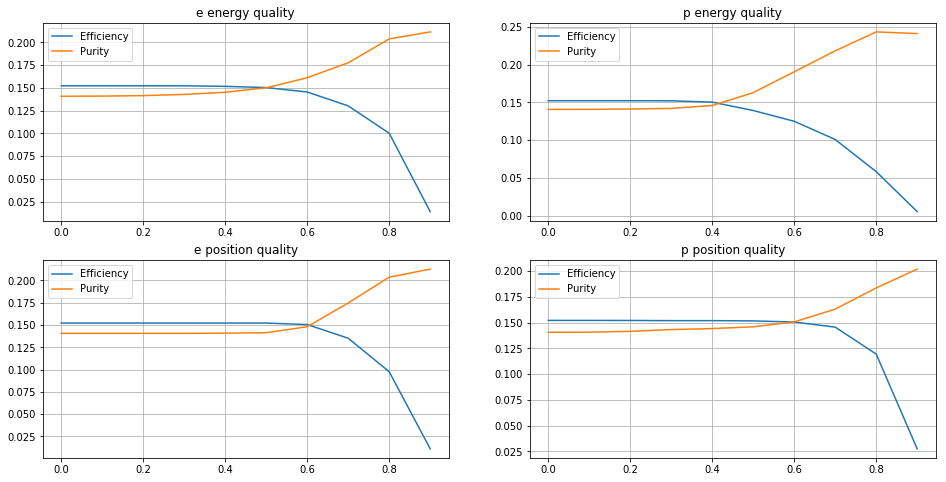

In [12]:
def plot_cross_evaluation(pos, title):
    l_quality = [None, .1, .2, .3, .4, .5, .6, .7, .8, .9]
    l_filter = [None, None, None, None]
    l_eff = []
    l_pur = []
    for i in l_quality:
        l_filter[pos] = i
        eff, pur = ai.calc_eff_pur(quality_filter=l_filter)
        l_eff.append(eff)
        l_pur.append(pur)

    plt.title(title)
    plt.plot(np.arange(0,1,.1), l_eff, label='Efficiency')
    plt.plot(np.arange(0,1,.1), l_pur, label='Purity')
    plt.grid()
    plt.legend()
    
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plot_cross_evaluation(0, 'e energy quality')
plt.subplot(2,2,2)
plot_cross_evaluation(1, 'p energy quality')
plt.subplot(2,2,3)
plot_cross_evaluation(2, 'e position quality')
plt.subplot(2,2,4)
plot_cross_evaluation(3, 'p position quality')
plt.show()